https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [76]:
import pandas as pd
from pandas import DataFrame, concat
import numpy as np
df_update = pd.read_csv('df_update.csv', index_col=[0])
skill_cell = pd.read_csv('skill_cell.csv',header=None)

In [77]:
skill_cell.columns=['skill_list']
skill_cell.head()

,skill_list
0,"Python, SQL, R, Spark, Hive, AWS, Data Warehouse, Business Intelligence, Network"
1,"SQL, R, Excel, Network"
2,"R, Excel"
3,"R, Microsoft Office, Excel, Marketing"
4,R


In [78]:
list_of_skill = skill_cell['skill_list'].to_list()

In [79]:
list_of_skill[:3]

['Python, SQL, R, Spark, Hive, AWS, Data Warehouse, Business Intelligence, Network',
 'SQL, R, Excel, Network',
 'R, Excel']

In [80]:
from nltk.tokenize import word_tokenize
example = list_of_skill
tokenized_sents = [word_tokenize(i) for i in example]

In [81]:
tokenized_sents

[['Python',
  ',',
  'SQL',
  ',',
  'R',
  ',',
  'Spark',
  ',',
  'Hive',
  ',',
  'AWS',
  ',',
  'Data',
  'Warehouse',
  ',',
  'Business',
  'Intelligence',
  ',',
  'Network'],
 ['SQL', ',', 'R', ',', 'Excel', ',', 'Network'],
 ['R', ',', 'Excel'],
 ['R', ',', 'Microsoft', 'Office', ',', 'Excel', ',', 'Marketing'],
 ['R'],
 ['R'],
 ['Python',
  ',',
  'SQL',
  ',',
  'R',
  ',',
  'Java',
  ',',
  'Tableau',
  ',',
  'AWS',
  ',',
  'Data',
  'Analysis',
  ',',
  'PostgreSQL',
  ',',
  'MySQL',
  ',',
  'S3',
  ',',
  'SaaS',
  ',',
  'SSH',
  ',',
  'Tomcat'],
 ['R', ',', 'Excel'],
 ['R', ',', 'Microsoft', 'Office', ',', 'Excel', ',', 'Go'],
 ['R'],
 ['SQL', ',', 'R', ',', 'Marketing', ',', 'CSS', ',', 'WordPress'],
 ['Software', 'Development', ',', '.Net', ',', 'C', '#', ',', 'SharePoint'],
 ['Python',
  ',',
  'SQL',
  ',',
  'R',
  ',',
  'Tableau',
  ',',
  'Linux',
  ',',
  'Go',
  ',',
  'CSS',
  ',',
  'GIS',
  ',',
  'Google',
  'Analytics',
  ',',
  'Omniture',
  ',',

In [82]:
for row in tokenized_sents:
    for i in row:
        if i == ',':
            row.remove(i)

In [83]:
tokenized_sents[:10]

[['Python',
  'SQL',
  'R',
  'Spark',
  'Hive',
  'AWS',
  'Data',
  'Warehouse',
  'Business',
  'Intelligence',
  'Network'],
 ['SQL', 'R', 'Excel', 'Network'],
 ['R', 'Excel'],
 ['R', 'Microsoft', 'Office', 'Excel', 'Marketing'],
 ['R'],
 ['R'],
 ['Python',
  'SQL',
  'R',
  'Java',
  'Tableau',
  'AWS',
  'Data',
  'Analysis',
  'PostgreSQL',
  'MySQL',
  'S3',
  'SaaS',
  'SSH',
  'Tomcat'],
 ['R', 'Excel'],
 ['R', 'Microsoft', 'Office', 'Excel', 'Go'],
 ['R']]

In [84]:
data_ready = tokenized_sents

In [85]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [87]:
num_topics = 3

In [88]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())


[(0,
  '0.221*"R" + 0.167*"Excel" + 0.071*"Management" + 0.058*"Microsoft" + '
  '0.049*"Office" + 0.048*"Marketing" + 0.043*"Visio" + 0.041*"Go" + '
  '0.036*"AI" + 0.029*"Project"'),
 (1,
  '0.191*"SQL" + 0.115*"R" + 0.085*"Tableau" + 0.070*"Accounting" + '
  '0.052*"SAS" + 0.051*"Python" + 0.045*"Go" + 0.026*"Google" + '
  '0.019*"Analytics" + 0.018*"Linux"'),
 (2,
  '0.102*"Business" + 0.079*"R" + 0.070*"SQL" + 0.065*"Intelligence" + '
  '0.060*"Data" + 0.048*"Excel" + 0.046*"Tableau" + 0.035*"Analysis" + '
  '0.032*"BI" + 0.032*"Power"')]


In [89]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_ready):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8417,"Business, R, SQL, Intelligence, Data, Excel, Tableau, Analysis, BI, Power","[Python, SQL, R, Spark, Hive, AWS, Data, Warehouse, Business, Intelligence, Network]"
1,1,0.0,0.6300,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project","[SQL, R, Excel, Network]"
2,2,0.0,0.7669,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project","[R, Excel]"
3,3,0.0,0.8870,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project","[R, Microsoft, Office, Excel, Marketing]"
4,4,0.0,0.6373,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project",[R]
5,5,0.0,0.6372,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project",[R]
6,6,2.0,0.6202,"Business, R, SQL, Intelligence, Data, Excel, Tableau, Analysis, BI, Power","[Python, SQL, R, Java, Tableau, AWS, Data, Analysis, PostgreSQL, MySQL, S3, SaaS, SSH, Tomcat]"
7,7,0.0,0.7669,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project","[R, Excel]"
8,8,0.0,0.8850,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project","[R, Microsoft, Office, Excel, Go]"
9,9,0.0,0.6372,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project",[R]


In [90]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9439,"R, Excel, Management, Microsoft, Office, Marketing, Visio, Go, AI, Project","[R, AI, Microsoft, Office, Excel, Project, Management, CI, PeopleSoft, Program, Management]"
1,1.0,0.9469,"SQL, R, Tableau, Accounting, SAS, Python, Go, Google, Analytics, Linux","[Python, SQL, R, Tableau, Linux, Go, CSS, GIS, Google, Analytics, Omniture, Workday]"
2,2.0,0.9641,"Business, R, SQL, Intelligence, Data, Excel, Tableau, Analysis, BI, Power","[Python, SQL, R, Java, Tableau, Big, Data, Data, Warehouse, Linux, JavaScript, Business, Intelli..."


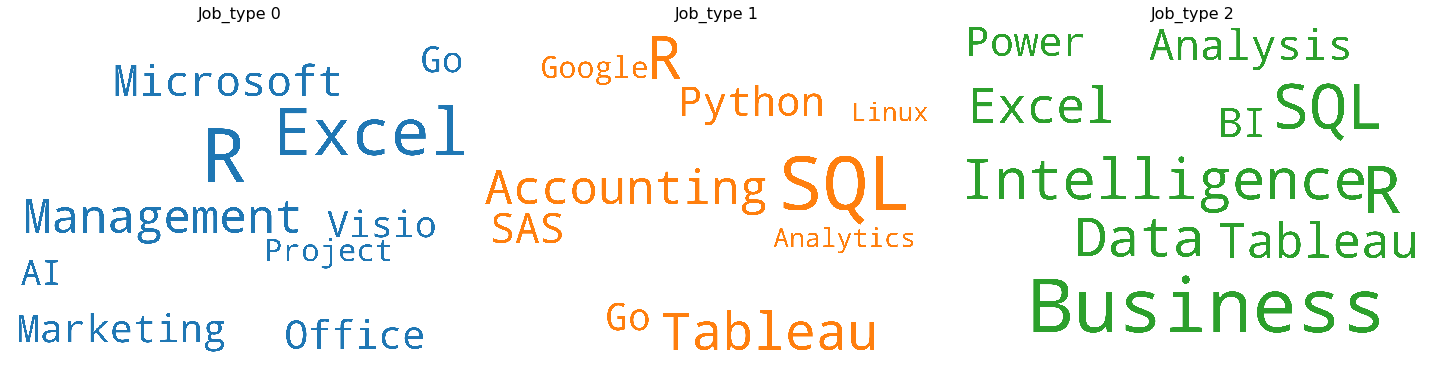

In [92]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, num_topics, figsize=(20,6), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Job_type ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

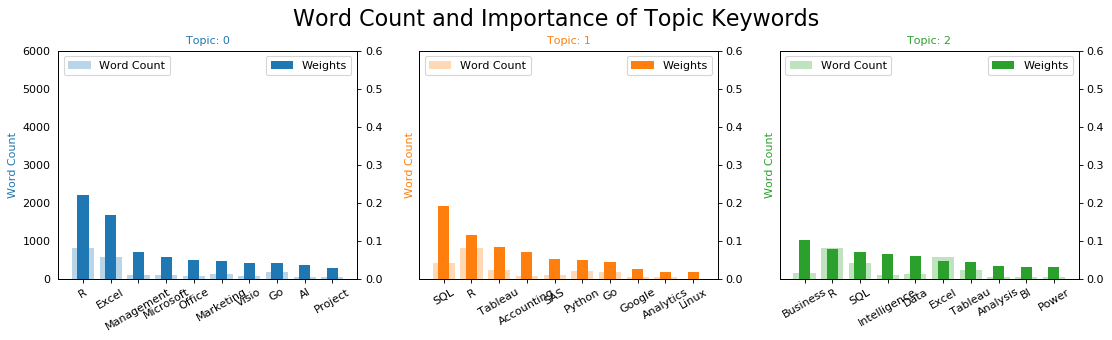

In [105]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(1, num_topics, figsize=(14,4), sharey=True, dpi=80)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.8, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.4, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.6); ax.set_ylim(0, 6000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'center')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=20, y=1.05)    
plt.show()

In [94]:
df.to_csv('df_topic.csv')

In [95]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 4]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

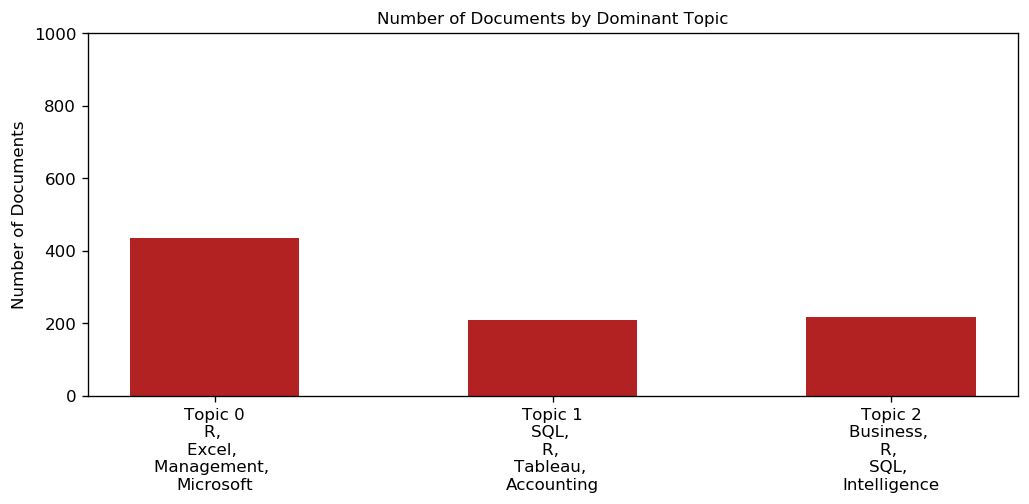

In [97]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

plt.show()

In [98]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=1200, plot_height=600)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 863 samples in 0.000s...
[t-SNE] Computed neighbors for 863 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 863 / 863
[t-SNE] Mean sigma: 0.000141
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.239773
[t-SNE] KL divergence after 1000 iterations: 0.215793


Loading BokehJS ...

In [99]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.284354  0.002720       1        1  37.683167
2      0.139165 -0.193968       2        1  33.755692
1      0.145189  0.191248       3        1  28.561148, topic_info=    Category        Freq          Term       Total  loglift  logprob
8    Default  411.000000           SQL  411.000000  30.0000  30.0000
1    Default  181.000000      Business  181.000000  29.0000  29.0000
11   Default  418.000000         Excel  418.000000  28.0000  28.0000
44   Default  141.000000    Management  141.000000  27.0000  27.0000
43   Default  104.000000    Accounting  104.000000  26.0000  26.0000
4    Default  115.000000  Intelligence  115.000000  25.0000  25.0000
22   Default  208.000000       Tableau  208.000000  24.0000  24.0000
2    Default  106.000000          Data  106.000000  23.0000  23.0000
13   Default  115.000000     Microsoft  115.000000  22.0000  22.0000
40   Default   78.000000           SAS   78.000000  21.0000  21.0000
14   Default   97.000000        Office   97.000000  20.0000  20.0000
12   Default   95.000000     Marketing   95.000000  19.0000  19.0000
55   Default   85.000000         Visio   85.000000  18.0000  18.0000
6    Default  126.000000        Python  126.000000  17.0000  17.0000
15   Default   63.000000      Analysis   63.000000  16.0000  16.0000
24   Default  148.000000            Go  148.000000  15.0000  15.0000
98   Default   56.000000            BI   56.000000  14.0000  14.0000
101  Default   56.000000         Power   56.000000  13.0000  13.0000
45   Default   58.000000       Project   58.000000  12.0000  12.0000
7    Default  750.000000             R  750.000000  11.0000  11.0000
35   Default   39.000000        Google   39.000000  10.0000  10.0000
53   Default   91.000000            AI   91.000000   9.0000   9.0000
107  Default   38.000000         Azure   38.000000   8.0000   8.0000
51   Default   42.000000            CI   42.000000   7.0000   7.0000
79   Default   37.000000        Oracle   37.000000   6.0000   6.0000
80   Default   36.000000          Jira   36.000000   5.0000   5.0000
33   Default   29.000000     Analytics   29.000000   4.0000   4.0000
16   Default   31.000000          Java   31.000000   3.0000   3.0000
56   Default   34.000000            UI   34.000000   2.0000   2.0000
31   Default   34.000000    SharePoint   34.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
66    Topic3   13.178830           XML   13.779894   1.2085  -4.7344
137   Topic3   12.011858       Windows   12.587275   1.2063  -4.8272
59    Topic3   10.944608      Platform   11.506739   1.2030  -4.9202
157   Topic3   10.727499         Basic   11.313360   1.1999  -4.9402
158   Topic3   10.727499        Visual   11.313360   1.1999  -4.9402
152   Topic3   10.642788     Reporting   11.232225   1.1992  -4.9482
151   Topic3   10.642788    Regulatory   11.232225   1.1992  -4.9482
17    Topic3   10.691029         MySQL   11.286284   1.1989  -4.9436
38    Topic3   10.069956       Workday   10.638962   1.1982  -5.0035
89    Topic3    9.684752    PowerShell   10.283174   1.1932  -5.0425
54    Topic3    9.361267           IDS    9.940340   1.1931  -5.0765
146   Topic3    9.327599      Hyperion    9.936110   1.1899  -5.0801
49    Topic3    9.088860      Research    9.720840   1.1859  -5.1060
110   Topic3   14.050627            RN   15.090387   1.1817  -4.6704
156   Topic3    9.813904         NoSQL   10.586733   1.1773  -5.0293
77    Topic3    9.772258         STATA   10.546483   1.1769  -5.0335
81    Topic3    7.356906           Git    7.960581   1.1743  -5.3174
39    Topic3   11.999797        MATLAB   13.076025   1.1672  -4.8282
63    Topic3    6.449103        Audits    7.038194   1.1657  -5.4491
48    Topic3    8.171803    Operations    8.921371   1.1654  -5.2124
198   Topic3    9.911094        Splunk   10.924341   1.1558  -5.0194
106   Topic3    5.308894      

In [74]:
p = pyLDAvis.gensim.prepare(lda_model, corpus, lda_model.id2word)
pyLDAvis.save_html(p, 'lda.html')

/Users/jz/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))
